# Inicjalizacja środowiska

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
warnings.filterwarnings('ignore')
from math import log

## Funkcje pomocnicze

In [178]:
def searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, min, max, step):
    scores = []
    values = []
    for C in np.arange(min, max, step):
        model = LogisticRegression(random_state=None, solver=solver, penalty=penalty, C=C).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        #score = metrics.f1_score(y_true=y_val, y_pred=y_pred)
        score = metrics.accuracy_score(y_val, y_pred)
        #cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        #score = np.abs(cv_scores).mean()
        scores.append(score)

        values.append(C)
    return scores, values

def testModelParameters(solver, penalty, X_train, y_train, X_val, y_val, plot=True, print_result=True):
    #0.1 2 0.01
    #0.01, 20, 0.5
    val_scores, values = searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, 0.01, 40, 1)
    if (plot):
        plt.figure()
        plt.plot(values, val_scores)
        plt.show()
    max = np.max(val_scores)
    idx = val_scores.index(max)
    C = values[idx]
    if(print_result):
        print("Największa wartość Accuracy na zbiorze walidacyjnym: %.4f \ndla współczynnika C = %.4f" %(max, C))
    return solver, penalty, C, max


# Dane wypełnione medianami

## Wczytanie danych

In [79]:
data = pd.read_csv("data/imputated_data.csv")
data = data.drop(['Imputated'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

# Wstępne przetwarzanie danych

In [122]:
y = data['Outcome']
X = data.drop(["Outcome"], axis=1)

## Dodanie dodatkowych cech

Funkcje interakcji najlepiej sprawdzają się w przypadku cech, które na wykresie cecha1(cecha2) układają się mniej więcej wzdłuż funkcji x=y oraz wraz z x rośnie prawdopodobieństwo wystąpienia pozytywnej decyzji. Z pomocą wykresów korelacji znalazłem jeden taki przypadek: Glucose oraz BMI.

In [74]:
'''
data['InsulinSquared'] = data['Insulin'].apply(lambda x: x**2)
data['GlucoseSquared'] = data['Glucose'].apply(lambda x: x**2)
data['InsulinGlucose'] = data['Insulin'] * data['Glucose']
data['BMISquared'] = data['BMI'].apply(lambda x:(x**2))
data['GlucoseBMI'] = data['Glucose'] * data['BMI']
data['InsulinLog'] = data['Insulin'].apply(lambda x: log(x))
data['BloodPressureSquared'] =  data['BloodPressure'].apply(lambda x: x**2)
data['SkinThicknessBMI'] = data['BMI'] * data['SkinThickness']
'''

"\ndata['InsulinSquared'] = data['Insulin'].apply(lambda x: x**2)\ndata['GlucoseSquared'] = data['Glucose'].apply(lambda x: x**2)\ndata['InsulinGlucose'] = data['Insulin'] * data['Glucose']\ndata['BMISquared'] = data['BMI'].apply(lambda x:(x**2))\ndata['GlucoseBMI'] = data['Glucose'] * data['BMI']\ndata['InsulinLog'] = data['Insulin'].apply(lambda x: log(x))\ndata['BloodPressureSquared'] =  data['BloodPressure'].apply(lambda x: x**2)\ndata['SkinThicknessBMI'] = data['BMI'] * data['SkinThickness']\n"

In [123]:
X['InsulinSquared'] = X['Insulin'].apply(lambda x: x**2)
X['GlucoseSquared'] = X['Glucose'].apply(lambda x: x**2)
X['InsulinGlucose'] = X['Insulin'] * X['Glucose']
X['BMISquared'] = X['BMI'].apply(lambda x:(x**2))
X['GlucoseBMI'] = X['Glucose'] * X['BMI']
X['InsulinLog'] = X['Insulin'].apply(lambda x: log(x))
X['BloodPressureSquared'] =  X['BloodPressure'].apply(lambda x: x**2)
X['SkinThicknessBMI'] = X['BMI'] * X['SkinThickness']

## Normalizacja 
Normilzację wykonuję tylko na podstawie wyników analizy zbioru z poprzedniego etapu. Cechy posiadające skośne rozkłady to: Pregnancies, Insulin, DiabetesPedigreeFunction oraz Age.

In [124]:
nscaler = MinMaxScaler() 
cols_to_norm = ['Pregnancies','Insulin','DiabetesPedigreeFunction','Age']
for col in cols_to_norm:
    cols= [col]
    nscaler.fit(X[cols])
    X[cols] = nscaler.transform(X[cols])

## Standaryzacja
Standaryzacja jest wymagana, ponieważ w dalszych krokach będę korzystać z regularyzacji. Standaryzacji poddaję wszystkie cechy.

In [125]:
scaler = StandardScaler()
cols_to_scale = X.columns.values
for col in X.columns.values:
    cols= [col]
    scaler.fit(X[cols])
    X[cols] = scaler.transform(X[cols])

## Podział danych
* Podział na zbiory X (cehcy opisujące) oraz Y (cecha opisywana). Dla tego zbioru Y to "Outcome", czyli diagnoza.
* Podział na zbiory Train/Test/Val - procentowy podział w komentarzu funkcji splitDataset()

In [5]:
def splitDataset(X, y, random_state=0, print_result=False):
    #Podział Train 60%, Test 20%, Val 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    #0.5 * 0.4 = 0.2
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    print("Zbiór podzielony: TRAIN: %i, VAL: %i, TEST: %i" % (X_train.shape[0],X_val.shape[0],X_test.shape[0]))
    return X_train, y_train, X_test, y_test, X_val, y_val

In [201]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, random_state=5, print_result=True)

Zbiór podzielony: TRAIN: 451, VAL: 151, TEST: 150


### Wybór ilości cech

Do doboru cech wykorzystuje metodę zachłanną. Model ma jednak włączoną regularyzację Lasso, dzięki czemu przy okazji będzie pozbywał się lub redukował wpływ tych mniej znaczących cech zmniejszając ich szansę na zostanie wybraną w danym etapie. Dla każdego etapu dodatkowo liczone jest współczynnik regularyzacji oferujący najlepszy wynik miary Accuracy. Zaimplementowałem to, ponieważ dla różnych ilości cech modele działają najlepiej dla różnych wartości C. Ponieważ regularyzacja jest stosowana za każdym razem to nie trzeba się obawiać overfittingu (choć później dla pewności należy sprawdzić), dzięki czemu zastosowanie samej miary Accuracy powinno wystarczyć do tego zadania.

In [193]:
features = X.columns.values.tolist()
result_features = []

cv_scores = []
best_c_cv_scores = []
feature_numbers = []

model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.1)
for n in range(0,len(features)):
    tmp_max_score = 0
    tmp_test_score = 0
    best_features = []
    for i,val in enumerate(features):
        tmp_features = result_features.copy()
        tmp_features.append(val)
        #score = cross_val_score(model, X_train[tmp_features], y_train)
        #score = np.abs(score).mean()
        solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[tmp_features], y_train, X_val[tmp_features], y_val, plot=False, print_result=False)
        score = max
        if( score > tmp_max_score ):
            tmp_max_score = score
            best_features = tmp_features
    result_features = best_features
    print("Dla %i cech najlepsza średnia wartość walidacji krzyżowej wynosi %.4f dla zbioru cech:\n%s" % (len(best_features), tmp_max_score, str(best_features)))
    cv_scores.append(tmp_max_score)
    feature_numbers.append(len(best_features))
    solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[best_features], y_train, X_val[best_features], y_val, plot=False, print_result=False)
    best_c_cv_scores.append(max)
    print("Dla najlepszego współczynnika C = %f średnia skuteczność przy walidacji krzyżowej wynosi %.4f" % (C,max))
    print("___________________________________________________________________________")
    features.remove(best_features[len(best_features)-1])

Dla 1 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.7616 dla zbioru cech:
['GlucoseBMI']
Dla najlepszego współczynnika C = 0.010000 średnia skuteczność przy walidacji krzyżowej wynosi 0.7616
___________________________________________________________________________
Dla 2 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.7748 dla zbioru cech:
['GlucoseBMI', 'Pregnancies']
Dla najlepszego współczynnika C = 1.010000 średnia skuteczność przy walidacji krzyżowej wynosi 0.7748
___________________________________________________________________________
Dla 3 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.7748 dla zbioru cech:
['GlucoseBMI', 'Pregnancies', 'SkinThickness']
Dla najlepszego współczynnika C = 1.010000 średnia skuteczność przy walidacji krzyżowej wynosi 0.7748
___________________________________________________________________________
Dla 4 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.7748 dla zbioru cech:
['GlucoseBMI', 'Pregna

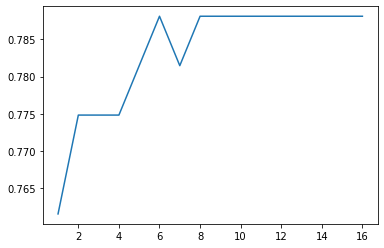

In [194]:
plt.figure()
plt.plot(feature_numbers, cv_scores)
plt.show()

In [199]:
features = ['GlucoseBMI', 'BMI', 'SkinThickness', 'DiabetesPedigreeFunction', 'Insulin', 'InsulinGlucose', 'InsulinSquared', 'InsulinLog'] #0.815
#features = ['GlucoseBMI', 'Age', 'BloodPressure', 'GlucoseSquared', 'Glucose', 'SkinThicknessBMI', 'BMI']


# Dobór parametrów

## Metoda regularyzacji
Ponieważ cechy są dobrane to model nie wymaga już redukcji ich wpływu lub usuwania, więc metoda Lasso nie jest tutaj oczywistym wyborem. Klasa LogisticRegression dla algorytmu liblinear oferuje regularyzacje L1 oraz L2. Wyboru można dokonać prostym porównaniem tych dwóch.

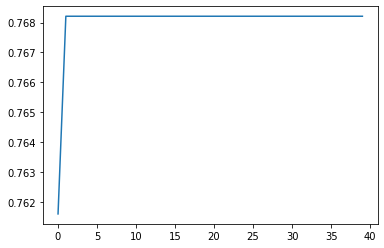

Największa wartość Accuracy na zbiorze walidacyjnym: 0.7682 
dla współczynnika C = 1.0100


In [200]:
solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[features], y_train, X_val[features], y_val)

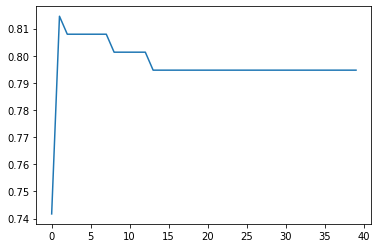

Największa wartość Accuracy na zbiorze walidacyjnym: 0.8146 
dla współczynnika C = 1.0100


In [181]:
solver, penalty, C, max = testModelParameters('liblinear','l2', X_train[features], y_train, X_val[features], y_val)

# Wynik, czyli teoretycznie najlepszy model

In [168]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=10.01).fit(X_train[features], y_train)

In [169]:
model.coef_

array([[ 0.23543383,  0.30818023,  0.06787657, -0.4722919 ,  1.27586321,
        -0.07428147,  0.46614032]])

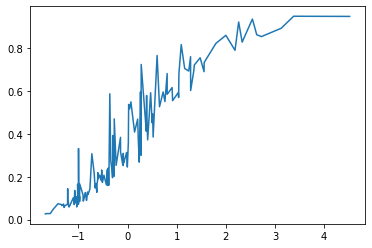

In [170]:
sorted = X_test.sort_values(by="GlucoseBMI")
model_values = (model.predict_proba(sorted[features]))
model_values[:,1]
plt.plot(sorted['GlucoseBMI'], model_values[:,1])

# Analiza utworzonego modelu

In [182]:
model = LogisticRegression(solver='liblinear', penalty='l1', C=2.01).fit(X_train[features], y_train) #4.1

In [183]:
y_pred = model.predict(X_test[features])

In [184]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1score = metrics.f1_score(y_test, y_pred)

In [185]:
print("Accuracy: %f\nPrecision: %f\nRecall: %f\nF1Score: %f" % (accuracy, precision, recall, f1score))

Accuracy: 0.780000
Precision: 0.735294
Recall: 0.510204
F1Score: 0.602410


In [176]:
metrics.confusion_matrix(y_test, y_pred)

array([[88, 13],
       [20, 29]], dtype=int64)

In [159]:
print(cross_val_score(model, X_train, y_train))

[0.78021978 0.75555556 0.73333333 0.74444444 0.73333333]


In [160]:
model.intercept_

array([-0.71581481])

In [161]:
model.classes_

array([0, 1], dtype=int64)

In [46]:
y_pred = 1*model.predict_proba(X_test[features])[:,1] > 0.2
metrics.confusion_matrix(y_test, y_pred)

array([[62, 39],
       [ 3, 46]], dtype=int64)

In [48]:
idx = 8
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.69).fit(X_train, y_train)
prediction = model.predict_proba(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
prediction = model.predict(X.iloc[idx,:].values.reshape(1,-1))
print(prediction)
pinw = np.linalg.pinv(X_train)
w = np.dot(pinw,y_train)
prediction = (w*X.iloc[idx,:]).sum()
print(prediction)
print(y.iloc[idx])

[[0.4962212 0.5037788]]
[1]
0.31716682338847013
1


In [55]:
print("Metoda macierzowa")
y_pred = ((w*X_val).sum(axis=1) > 0.1) * 1
print(metrics.confusion_matrix(y_val, y_pred))

print("LogisticRegression")
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=4.51).fit(X_train, y_train)
y_pred = model.predict(X_val)
print(metrics.confusion_matrix(y_val, y_pred))

Metoda macierzowa
[[82 17]
 [22 30]]
LogisticRegression
[[88 11]
 [21 31]]


In [58]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1',C=1.01).fit(X_train, y_train)
model.score(X_test, y_test)
print(model.coef_)
y_pred = model.predict(X_val)
metrics.roc_auc_score(y_val,y_pred )

[[ 0.47741912  0.58267458  0.00273318  0.0037763   0.          0.67468893
   0.26515814  0.03434957 -0.17250796  0.          0.         -0.49765947
   0.68879295 -0.08909132  0.          0.        ]]


0.7379564879564879

In [59]:

model = LogisticRegression(random_state=None, solver='liblinear', penalty='l1', C=1.49).fit(X_train, y_train)
scores = cross_val_score(model, X, y, cv=5 )
print(scores)
print(model.coef_)

[0.75496689 0.73509934 0.78       0.78666667 0.76666667]
[[ 4.77818310e-01  6.47220224e-01  1.60081945e-02  1.01781806e-03
   0.00000000e+00  1.09090023e+00  2.70578177e-01  3.14115864e-02
  -1.81592986e-01  0.00000000e+00  0.00000000e+00 -8.53637568e-01
   6.06285758e-01 -9.02086068e-02  0.00000000e+00  0.00000000e+00]]


In [36]:

scores = cross_val_score(model, X, y, cv=5)
scores

array([0.7615894 , 0.74834437, 0.76      , 0.78666667, 0.77333333])

# Testowanie modelu #
#TODO

# Wypełnienie braków przy użyciu regresji
#TODO